In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.offline as py
py.init_notebook_mode()
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row',200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', -1)


In C:\Users\Jalal\AppData\Local\New folder\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jalal\AppData\Local\New folder\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jalal\AppData\Local\New folder\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jalal\AppData\Local\New folder\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jalal\AppData\Local\

In [2]:
sales_train = pd.read_csv(r"C:\Users\Jalal\Desktop\Programing\Capstones\Final Capstone\Data\sales prediction\sales_train.csv")
item_categories = pd.read_csv(r"C:\Users\Jalal\Desktop\Programing\Capstones\Final Capstone\Data\sales prediction\item_categories.csv")
items = pd.read_csv(r"C:\Users\Jalal\Desktop\Programing\Capstones\Final Capstone\Data\sales prediction\items.csv")
shops = pd.read_csv(r"C:\Users\Jalal\Desktop\Programing\Capstones\Final Capstone\Data\sales prediction\shops.csv")
# test = pd.read_csv(r"C:\Users\Jalal\Desktop\Programing\Capstones\Final Capstone\Data\sales prediction\test.csv")
# sales['date'] = pd.to_datetime(sales['date'])
# sales['month'] = pd.to_datetime(sales['date']).dt.month
# sales['year'] = pd.to_datetime(sales['date']).dt.year

In [3]:
item_info = pd.merge(items, item_categories, on='item_category_id', how='inner')
train_tmp = pd.merge(sales_train,item_info, on='item_id', how='inner')
train = pd.merge(train_tmp, shops, on='shop_id', how='inner')
# train.head(3)

In [4]:
train.date = pd.to_datetime(train.date,format='%d.%m.%Y')
train =  train.sort_values('date').reset_index(drop=True)
train = train[(train.item_price < 100000) & (train.item_price > 0)]
train = train[(train.item_cnt_day < 1001) & (train.item_cnt_day > 0)]
train['total_sales'] = train['item_price'] * train['item_cnt_day']
# train.head(3)

In [5]:
train['date_block_num'] =train['date_block_num'].astype(np.int8)
train['shop_id'] = train['shop_id'].astype(np.int8)
train['item_id'] = train['item_id'].astype(np.int16)
train['item_category_id'] = train['item_category_id'].astype(np.int16)

In [6]:
# plt.figure(figsize = (12,7))
# train.date_block_num.value_counts().sort_index().plot()
# plt.xlabel('date_block_num')
# plt.ylabel('count')

In [7]:
# plt.figure(figsize = (12,7))
# sns.lineplot('date_block_num', 'total_sales' , data = train, estimator = 'sum', ci=False)

In [8]:
# def test_stationarity(timeseries):
    
#     #Perform Dickey-Fuller test:
#     print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

# test_stationarity(train.total_sales)

In [9]:
# print('ADF testing ...')
# print(f"p-value[total_sales] : {adfuller(monthly_ts['total_sales'].values, autolag='AIC', regression = 'ct')[1]}")
# print(f"p-value[item_cnt_day] : {adfuller(monthly_ts['item_cnt_day'].values, autolag='AIC', regression = 'ct')[1]}")

In [10]:
monthly_ts = train.groupby(["date_block_num"])["total_sales","item_cnt_day"].sum()

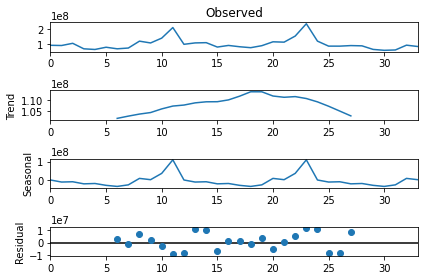

In [11]:
sales_dec = sm.tsa.seasonal_decompose(monthly_ts["total_sales"].values,period=12,model="additative").plot()
# monthly_ts


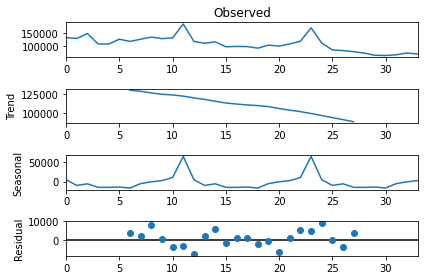

In [12]:
sales_dec = sm.tsa.seasonal_decompose(monthly_ts["item_cnt_day"].values,period=12,model="additative").plot()


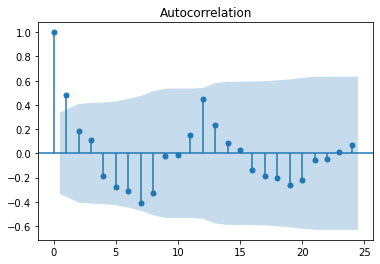

In [13]:
sales_acf = sm.graphics.tsa.plot_acf(monthly_ts["total_sales"].values, lags=24)

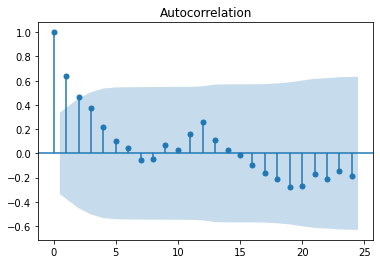

In [14]:
item_cnt_acf = sm.graphics.tsa.plot_acf(monthly_ts["item_cnt_day"].values, lags=24)

In [15]:
# def fill_anomaly(x, trg):
#     shop_id = int(x.shop_id)
#     item_id = int(x.item_id)
#     db_num = int(x.date_block_num)
#     ret = train[(train.shop_id==shop_id)&(train.item_id==item_id)&(train.date_block_num==db_num)&(train.item_cnt_day<1000)&(train.item_cnt_day>=0)&(train.item_price<100000)&(train.item_price>=0)][trg].mean()
#     if np.isnan(ret):
#         ret = train[(train.shop_id==shop_id)&(train.item_id==item_id)&(train.item_cnt_day<1000)&(train.item_cnt_day>=0)&(train.item_price<100000)&(train.item_price>=0)][trg].mean()
#     if np.isnan(ret):
#         ret = train[(train.item_id==item_id)&(train.item_cnt_day<1000)&(train.item_cnt_day>=0)&(train.item_price<100000)&(train.item_price>=0)][trg].mean()
#     if np.isnan(ret):
#         ret = train[(train.shop_id==shop_id)&(train.item_cnt_day<1000)&(train.item_cnt_day>=0)&(train.item_price<100000)&(train.item_price>=0)][trg].mean()
#     return ret

In [16]:
# tmp = train[['date_block_num','shop_id','item_id','item_price','item_cnt_day']]

# train.loc[(train['item_cnt_day'] < 0),'item_cnt_day'] = tmp[tmp['item_cnt_day'] < 0].apply(fill_anomaly, trg='item_cnt_day', axis=1)
# train.loc[(train['item_cnt_day'] > 1000),'item_cnt_day'] = tmp[tmp['item_cnt_day'] > 1000].apply(fill_anomaly, trg='item_cnt_day', axis=1)
# train.loc[(train['item_price'] < 0),'item_price'] = tmp[tmp['item_price'] < 0]._apply(fill_anomaly, trg='item_price', axis=1)
# train.loc[(train['item_price'] > 100000),'item_price'] = tmp[tmp['item_price'] > 100000].apply(fill_anomaly, trg='item_price', axis=1)
# #recalculate total_sales
# train['total_sales'] = train['item_price'] * train['item_cnt_day']

### Using Prophet Model From fbprophet

In [17]:
prophet_df = pd.DataFrame()
prophet_df['ds'] = pd.date_range(start = '2013-01-01',end='2015-11-01', freq = 'M')
prophet_df['y'] = train.groupby(["date_block_num"])["total_sales"].sum()
prophet_df.columns

Index(['ds', 'y'], dtype='object')

In [18]:
m1 = Prophet() #changepoint_prior_scale=0.08
m1.fit(prophet_df)
future1 = m1.make_future_dataframe(periods = 3, freq = 'M')
forecast1 = m1.predict(future1)
forecast1.tail(3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
34,2015-11-30,9.259870e+07,1.206408e+08,1.296101e+08,9.253183e+07,9.267279e+07,3.233926e+07,3.233926e+07,3.233926e+07,3.233926e+07,3.233926e+07,3.233926e+07,0.0,0.0,0.0,1.249380e+08
35,2015-12-31,9.002003e+07,2.070786e+08,2.156301e+08,8.975646e+07,9.030387e+07,1.211919e+08,1.211919e+08,1.211919e+08,1.211919e+08,1.211919e+08,1.211919e+08,0.0,0.0,0.0,2.112120e+08
36,2016-01-31,8.744137e+07,8.371404e+07,9.220972e+07,8.692931e+07,8.802810e+07,4.452357e+05,4.452357e+05,4.452357e+05,4.452357e+05,4.452357e+05,4.452357e+05,0.0,0.0,0.0,8.788661e+07


Text(56.625, 0.5, 'Sales')

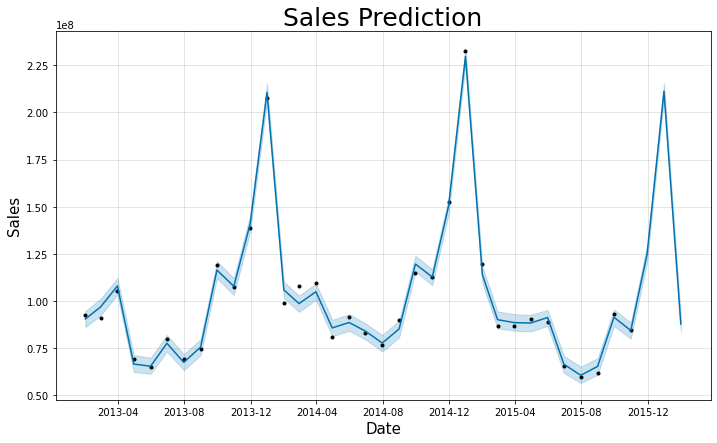

In [19]:
fig1 = m1.plot(forecast1)
ax = fig1.gca()
ax.set_title("Sales Prediction", size=25)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
# a = add_changepoints_to_plot(ax, m, prophe_result)

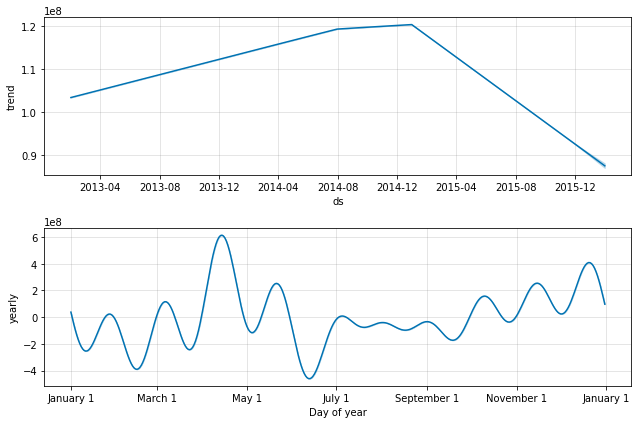

In [20]:
fig2 = m1.plot_components(forecast1)

In [21]:
# prophet_df.y.plot()

In [22]:
# prophet_df.shape

In [23]:
prophet_df2_train = prophet_df[:26]
prophet_df2_val = prophet_df[26:]

prophet_df2_val.shape

(8, 2)

In [24]:
m2 = Prophet(seasonality_mode='multiplicative') #changepoint_prior_scale=0.08
m2.fit(prophet_df2_train)
future2 = m2.make_future_dataframe(periods = 8, freq = 'M')
forecast2 = m2.predict(future2)
# forecast2.tail(3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


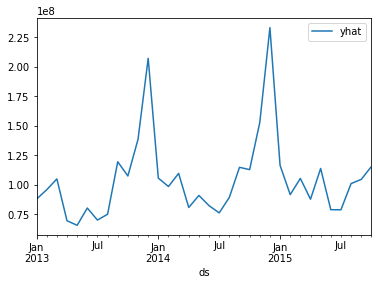

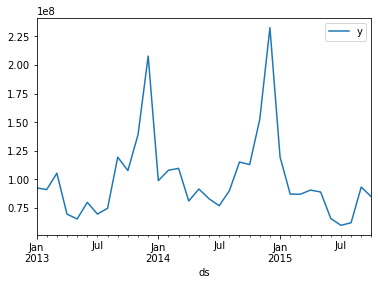

In [25]:
# m2.plot(forecast2)
forecast2.plot('ds', 'yhat')
prophet_df.plot('ds','y')
plt.legend()

# ax = fig1.gca()
# ax.set_title("Sales Prediction", size=25)
# ax.set_xlabel("Date", size=15)
# ax.set_ylabel("Sales", size=15)
# # prophet_df.plot()

# a = add_changepoints_to_plot(ax, m, prophe_result)

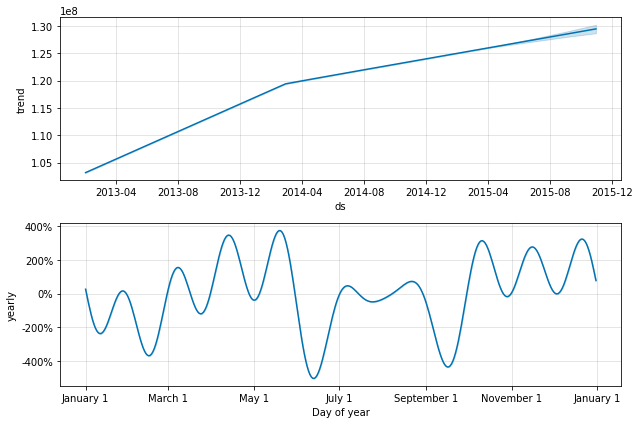

In [26]:
fig3 = m2.plot_components(forecast2)

In [27]:
# df_cv = cross_validation(m2, initial='33 days', horizon = '70 days') # , period='365 days', initial='1033 days'

In [28]:
# df_p = performance_metrics(df_cv)
# df_p.shape

NameError: name 'df_cv' is not defined

In [ ]:
# prophet_df.plot('ds','y')

In [29]:
# r2_score(prophet_df.y, forecast2.yhat)

0.9045509389500814

In [30]:
# mean_squared_error(prophet_df.y, forecast2.yhat)

127916085146837.56

In [31]:
#  mean_absolute_error(prophet_df.y, forecast2.yhat)

5904097.960177973

In [32]:
# forecast2.yhat.mean()

104835548.26675746

In [33]:
# forecast2.yhat.std()

35301239.71620196

## Prophet Model with with train_test split

In [35]:
prophet_df = pd.DataFrame()
prophet_df['ds'] = pd.date_range(start = '2013-01-01',end='2015-11-01', freq = 'M')
prophet_df['y'] = train.groupby(["date_block_num"])["total_sales"].sum()
# prophet_df.columns
prophet_df_train = prophet_df[:28]
prophet_df_test = prophet_df[28:]

m3 = Prophet() #changepoint_prior_scale=0.08
m3.fit(prophet_df_train)
future3 = m3.make_future_dataframe(periods = 6, freq = 'M')
forecast3 = m3.predict(future3)
forecast3_short = forecast3[['ds', 'yhat']]
forecast3_short.loc[:, 'y'] = prophet_df['y']
# forecast3_short

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


In [36]:
np.round(mean_absolute_error(forecast3_short.yhat, forecast3_short.y))

6012497.0

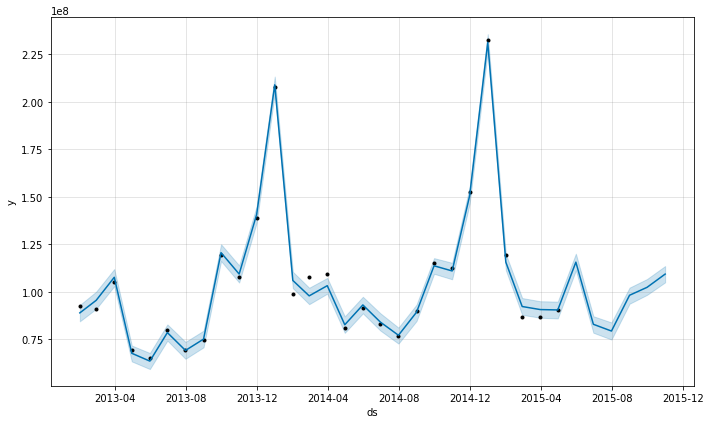

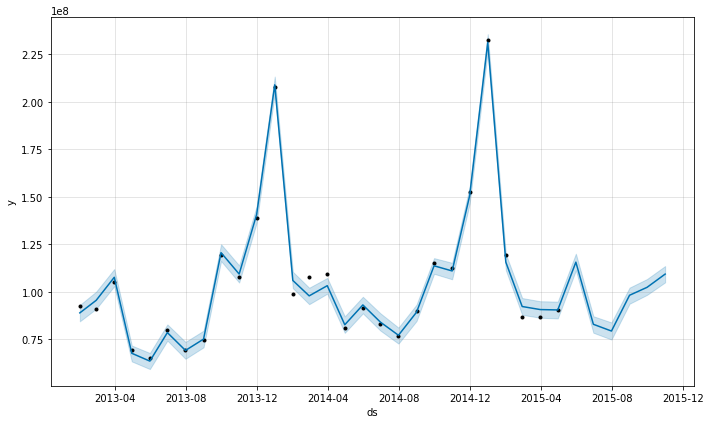

In [37]:
m3.plot(forecast3)

<AxesSubplot:xlabel='ds', ylabel='yhat'>

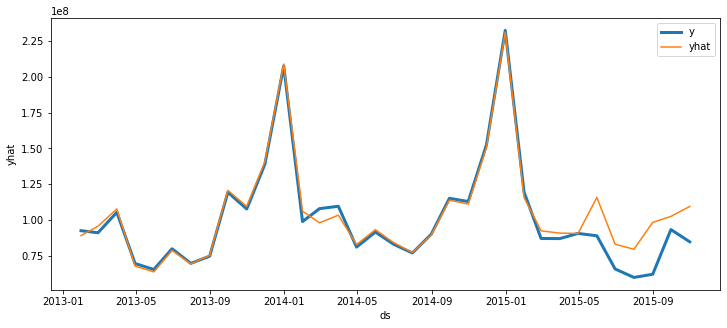

In [38]:
plt.figure(figsize = (12,5))
sns.lineplot('ds', 'y', data = forecast3_short, label = 'y', linewidth = 3)
sns.lineplot('ds', 'yhat', data = forecast3_short ,label ='yhat')

## Prophet Model with Log Transformation 

In [ ]:
# prophet_df = pd.DataFrame()
# prophet_df['ds'] = pd.date_range(start = '2013-01-01',end='2015-11-01', freq = 'M')
# prophet_df['y'] = train.groupby(["date_block_num"])["total_sales"].sum()
# # prophet_df.columns
# prophet_df_l = prophet_df
# prophet_df_l.loc[:,'orig_y'] = prophet_df_l['y']
# prophet_df_l['y'] = np.log(prophet_df_l.y)
# prophet_df_log = prophet_df_l
# # = prophet_df.copy()
# prophet_df_log  = prophet_df_log.drop('orig_y', axis = 1)
# # prophet_df_log


In [ ]:
# m4 = Prophet(seasonality_mode='multiplicative')
# m4.fit(prophet_df_log)
# future4 = m4.make_future_dataframe(periods = 8, freq = 'M')
# forecast4 = m4.predict(future4)
# # forecast4.head()

In [ ]:
# forecast4_short = forecast4[['ds', 'yhat']]
# # forecast4_short
# # prophet_df_yhat.loc[:,'yhat'] = forecast3_short['yhat']
# forecast4_short.loc[:, 'y'] = prophet_df_log['y']
# forecast4_short = forecast4_short[:34]
# # forecast4_short

In [ ]:
# forecast4_short.yhat = np.exp(forecast4_short.yhat)
# forecast4_short.y = np.exp(forecast4_short.y)
# # forecast4_short

In [ ]:
# np.round(mean_absolute_error(forecast4_short.yhat, forecast4_short.y))

In [ ]:
# r2_score(forecast4_short.y, forecast4_short.yhat)

In [ ]:
# plt.figure(figsize = (12,5))
# sns.lineplot('ds', 'y', data = forecast4_short, label = 'y', linewidth = 3)
# sns.lineplot('ds', 'yhat', data = forecast4_short ,label ='yhat')

## Prophet Model with Log Transformation and train_test spliting

In [39]:
prophet_df = pd.DataFrame()
prophet_df['ds'] = pd.date_range(start = '2013-01-01',end='2015-11-01', freq = 'M')
prophet_df['y'] = train.groupby(["date_block_num"])["total_sales"].sum()
prophet_df_train = prophet_df[:28]
prophet_df_test = prophet_df[28:]
# prophet_df_l = prophet_df
prophet_df_train.loc[:,'orig_y'] = prophet_df_train['y']
prophet_df_train['y'] = np.log(prophet_df_train.y)
prophet_df_log = prophet_df_train
# = prophet_df.copy()
prophet_df_log  = prophet_df_log.drop('orig_y', axis = 1)
# prophet_df_log

In [40]:
m5 = Prophet(seasonality_mode='multiplicative')
m5.fit(prophet_df_log)
future5 = m5.make_future_dataframe(periods = 6, freq = 'M')
forecast5 = m5.predict(future5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


In [ ]:
forecast5_short.columns

In [41]:
forecast5_short = forecast5[['ds', 'yhat']]
forecast5_short.loc[:, 'y'] = prophet_df['y']

In [42]:
forecast5_short.yhat = np.exp(forecast5_short.yhat)

In [43]:
np.round(mean_absolute_error(forecast5_short.yhat, forecast5_short.y))

10669484.0

<AxesSubplot:xlabel='ds', ylabel='yhat'>

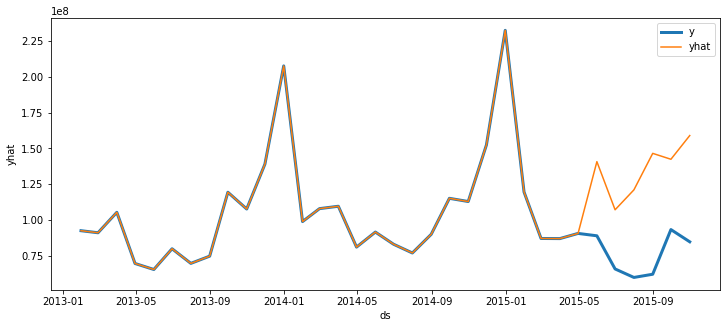

In [45]:
plt.figure(figsize = (12,5))
sns.lineplot('ds', 'y', data = forecast5_short, label = 'y', linewidth = 3)
sns.lineplot('ds', 'yhat', data = forecast5_short ,label ='yhat')

In [ ]:
r2_score(forecast5_short.y[28:], forecast5_short.yhat[28:])

In [ ]:
train['date'].min() ,  train['date'].max()

In [ ]:
train['date'].min() -  train['date'].max()

In [ ]:
prophet_df.ds.max() , prophet_df.ds.min()

In [ ]:
prophet_df.ds.max() - prophet_df.ds.min()

In [ ]:
!jupyter nbconvert --to html sales_prediction.ipynb